In [86]:
%load_ext autoreload
%autoreload 2

In [125]:
import pandas as pd
import os
import numpy as np

In [243]:
models = ["gpt-4o", "gpt-4o-mini", "llama3.1-8b-instruct-q4_0"]
setting = [""]
results_path = "../results/llms"
ground_truth_path = "../results/ground_truth.csv"

In [244]:
def update_unsat_results(df, ground_truth_df):
    labels = []
    for i, row in df.iterrows():
        if row["result"] == "UNSAT" or row.get("status") == "unsat":
            labels.append(int(ground_truth_df.loc[i]["status"] == "unsat"))
        else:
            labels.append(row["valid?"])

    df["valid?"] = labels
    return df


def get_result(df, ground_truth_df):
    df["label"] = ground_truth_df["status"]
    df_sat = df[df["label"] != "unsat"]
    df_unsat = df[df["label"] == "unsat"]
    if "status" in df.columns:
        df_predicted_unsat = df[df["status"] == "unsat"]
        df_predicted_sat = df[df["status"] == "sat"]
    else:
        df_predicted_unsat = df[df["result"] == "UNSAT"]
        df_predicted_sat = df[df["result"] != "UNSAT"]

    generation_success_rate = df_sat["valid?"].sum() / len(df_sat)

    unsat_recall = df_unsat["valid?"].sum() / len(df_unsat) if len(df_unsat) > 0 else 1
    unsat_precision = (
        df_predicted_unsat["valid?"].sum() / len(df_predicted_unsat)
        if len(df_predicted_unsat) > 0
        else 1
    )
    unsat_f1 = (
        2 * unsat_precision * unsat_recall / (unsat_precision + unsat_recall)
        if unsat_precision + unsat_recall > 0
        else 0
    )
    return {
        "generation_success_rate": generation_success_rate,
        "unsat_recall": unsat_recall,
        "unsat_precision": unsat_precision,
        "unsat_f1": unsat_f1,
    }

In [245]:
ground_truth = pd.read_csv(ground_truth_path)

In [246]:
from loguru import logger
input_folder = "../results/generation_with_generated"

# llms = ["gpt-4o-mini", "gpt-4o", "deepseek-chat", "llama3.1-8b"]
llms = ["gpt-4o-mini", "gpt-4o", "deepseek-chat", "llama3.1-8b"]
constraint_llms = ["deepseek-chat", "gpt-4o-mini"]
approaches = ["vfe",]

results = {}

for llm in llms:
    for constraint_llm in constraint_llms:
        for approach in approaches:
            logger.info(f"Processing {llm} with {constraint_llm} using {approach}")
            result_file = f"{input_folder}/{llm}/{approach}_{constraint_llm}.csv_validation.csv"
            if not os.path.exists(result_file):
                logger.warning(f"File {result_file} does not exist")
                continue
            df = pd.read_csv(result_file)
            df = update_unsat_results(df, ground_truth)
            results[(llm, constraint_llm, approach)] = df


2025-03-09 00:46:47.730 | INFO     | __main__:<module>:14 - Processing gpt-4o-mini with deepseek-chat using vfe
2025-03-09 00:46:47.742 | INFO     | __main__:<module>:14 - Processing gpt-4o-mini with gpt-4o-mini using vfe
2025-03-09 00:46:47.756 | INFO     | __main__:<module>:14 - Processing gpt-4o with deepseek-chat using vfe
2025-03-09 00:46:47.767 | INFO     | __main__:<module>:14 - Processing gpt-4o with gpt-4o-mini using vfe
2025-03-09 00:46:47.777 | INFO     | __main__:<module>:14 - Processing deepseek-chat with deepseek-chat using vfe
2025-03-09 00:46:47.789 | INFO     | __main__:<module>:14 - Processing deepseek-chat with gpt-4o-mini using vfe


2025-03-09 00:46:47.824 | INFO     | __main__:<module>:14 - Processing llama3.1-8b with deepseek-chat using vfe
2025-03-09 00:46:47.835 | INFO     | __main__:<module>:14 - Processing llama3.1-8b with gpt-4o-mini using vfe


In [247]:
llm_folder = "../results/generation"

for llm in llms:
    result_file = f"{llm_folder}/{llm}.csv_validation.csv"
    
    if not os.path.exists(result_file):
        logger.warning(f"Config {llm} does not exist")
        continue

    df = pd.read_csv(result_file)
    df = update_unsat_results(df, ground_truth)
    results[f"{llm}"] = df

In [248]:
# Load generation from ground truth constraints
approach_map = {
    "vfe": "explanation",
}

for llm in llms:
    for approach in approaches:
        result_file = f"../results/generation_with_gt/{approach_map[approach]}/hybrid/{llm}.csv_validation.csv"
        if not os.path.exists(result_file):
            logger.warning(f"File {result_file} does not exist")
            continue
        df = pd.read_csv(result_file)
        df = update_unsat_results(df, ground_truth)
        results[(llm, "ground_truth", approach)] = df

In [249]:
accuracy = {}

for key in results.keys():
        result = results[key]
        accuracy[key] = get_result(result, ground_truth)

In [250]:
summarized_results = []
for key, value in accuracy.items():
    value["approach"] = key
    summarized_results.append(value)

summarized_results = pd.DataFrame(summarized_results)

In [251]:
summarized_results

,generation_success_rate,unsat_recall,unsat_precision,unsat_f1,approach
0,0.749117,0.754386,0.716667,0.735043,"(gpt-4o-mini, deepseek-chat, vfe)"
1,0.745583,0.614035,0.648148,0.630631,"(gpt-4o-mini, gpt-4o-mini, vfe)"
2,0.908127,0.649123,0.925000,0.762887,"(gpt-4o, deepseek-chat, vfe)"
3,0.872792,0.491228,0.933333,0.643678,"(gpt-4o, gpt-4o-mini, vfe)"
4,0.890459,0.649123,0.840909,0.732673,"(deepseek-chat, deepseek-chat, vfe)"
5,0.858657,0.561404,0.820513,0.666667,"(deepseek-chat, gpt-4o-mini, vfe)"
6,0.452297,0.596491,0.576271,0.586207,"(llama3.1-8b, deepseek-chat, vfe)"
7,0.466431,0.508772,0.604167,0.552381,"(llama3.1-8b, gpt-4o-mini, vfe)"
8,0.664311,0.614035,0.583333,0.598291,gpt-4o-mini
9,0.784452,0.491228,0.903226,0.636364,gpt-4o


In [252]:
def get_result_for_llm(results, llm_name, approach_name, constraint_llm_name: str= None):
    if constraint_llm_name is not None:
        key = (llm_name, constraint_llm_name, approach_name)
    elif approach_name == "direct":
        key = llm_name
    else:
        raise ValueError(f"Invalid approach {approach_name}")

    for result in results:
        if result["approach"] == key:
            return [result["generation_success_rate"], result["unsat_precision"], result["unsat_f1"], result["unsat_recall"]]
    logger.warning(f"Result for {key} not found")
    return [0, 0, 0, 0]

In [253]:
results[0]

KeyError: 0

In [269]:
results = summarized_results.to_dict(orient="records")
llm_name = {
    "gpt-4o": "GPT-4o",
    "gpt-4o-mini": "GPT-40-mini",
    "llama3.1-8b": "Llama3.1-8b",
    "deepseek-chat": "DeepSeek-V3",
}

data = [["GRS", "P", "F1", "R"]]
for llm in llms:
    llm_data = []
    for approach in approaches:
        for constraint_llm in constraint_llms:
            llm_result = get_result_for_llm(results, llm, approach, constraint_llm)
            if llm_result is not None:
                llm_data.append(llm_result)
        llm_data.append(get_result_for_llm(results, llm, "vfe", "ground_truth"))
    llm_data.append(get_result_for_llm(results, llm, "direct"))
    data.append((llm_name[llm], llm_data))


[0.         1.57079633 3.14159265 4.71238898]


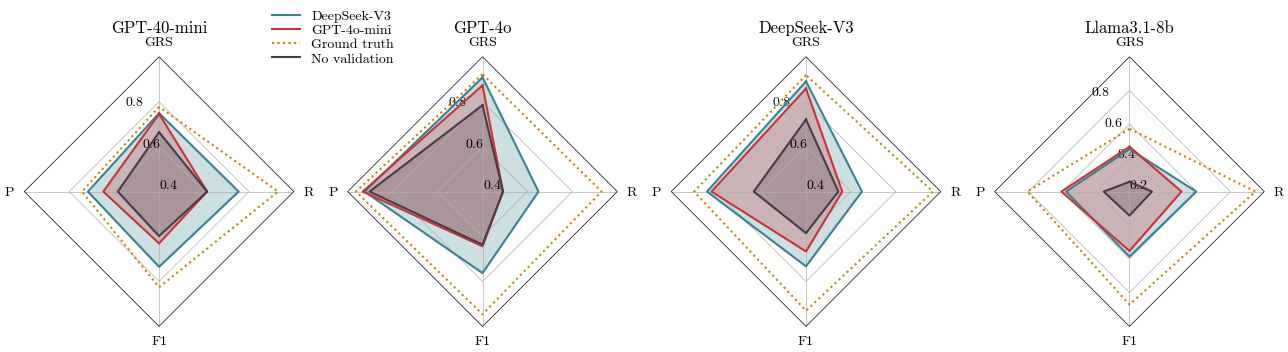

In [ ]:
import matplotlib.pyplot as plt
import scienceplots
import numpy as np
from utils import radar_factory

N = 4
theta = radar_factory(N, frame='polygon')
print(theta)

# data = example_data()
spoke_labels = data.pop(0)

fig, axs = plt.subplots(figsize=(16, 4), nrows=1, ncols=4,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.2, hspace=0.20, top=0.85, bottom=0.05)

colors = ["#3a8093", "#c73535", "#C98003", '#483C46', '#FFB5C2']
linestyles = ['-', '-', ':', '-']

# "#3a8093", "#fcb944", "#c73535"
# Plot the four cases from the example data on separate Axes
for ax, (title, case_data) in zip(axs.flat, data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='large', position=(0.5, 1.2),
                    horizontalalignment='center', verticalalignment='center')
    # set axis ticks and labels
    

    for idx, (d, color) in enumerate(zip(case_data, colors)):
        ax.plot(theta, d, color=color, linestyle=linestyles[idx], linewidth=1.5)
        if idx != 2:
            ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)
    # ax.set_yticks([0.5, 1])
    if title == "Llama3.1-8b":
        ax.set_ylim(0.2, 1)
    else:
        ax.set_ylim(0.4, 1)
# add legend relative to top-left plot
labels = ('DeepSeek-V3', 'GPT-4o-mini', 'Ground truth', 'No validation')
legend = axs[0].legend(labels, loc=(0.9, .95),
                            labelspacing=0.1, fontsize='medium')

# fig.text(0.5, 1.7, '5-Factor Solution Profiles Across Four Scenarios',
#          horizontalalignment='center', color='black', weight='bold',
#          size='large')

plt.savefig("radar_plot.pdf", bbox_inches='tight')
plt.show()